In [1]:
import keras
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

'2.3.1'

Data preprocessing

In [2]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    nOfZeros = np.count_nonzero(train_set[0]==0)
    nOfZeros += np.count_nonzero(val_set[0]==0)
    nOfZeros += np.count_nonzero(test_set[0]==0)
    print("number of zeros(before padding): {}".format(nOfZeros))
    print("Train dataset shape: ", train_set[0].shape)
    print("Validation dataset shape: ", val_set[0].shape)
    print("Test dataset shape: ", test_set[0].shape)
    return train_set, val_set, test_set

In [3]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels
    
from sklearn.model_selection import StratifiedShuffleSplit
def balancedSplitting(features, labels, test_size = 0.5):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size)
    for train_idx, test_idx in sss.split(features, labels):
        X_train = features[train_idx]
        y_train = labels[train_idx]
        X_test = features[test_idx]
        y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test
    
    
from keras.preprocessing.sequence import pad_sequences
def padding(features, max):
    maxLength = max([len(s) for s in  features])
    newFeatures = pad_sequences(features, maxlen=None, dtype='float32', padding='post', truncating='post', value=0.0)
    lenght = newFeatures.shape[0] * newFeatures.shape[1]*newFeatures.shape[2]*newFeatures.shape[3]
    numberOfZeros = np.count_nonzero(newFeatures==0)
    print("number of zeros(after padding): {} - {:.2f}%".format(numberOfZeros, numberOfZeros/(lenght)*100))
    print("Dataset shape: ", newFeatures.shape)
    return newFeatures

def paddingTrainValTest(X_train, X_val, X_test):
    maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    newXtrain = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXval = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    newXtest = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    lenghtTrain = newXtrain.shape[0] * newXtrain.shape[1]*newXtrain.shape[2]*newXtrain.shape[3]
    lenghtVal = newXval.shape[0] * newXval.shape[1]*newXval.shape[2]*newXval.shape[3]
    lenghtTest = newXtest.shape[0] * newXtest.shape[1]*newXtest.shape[2]*newXtest.shape[3]
    numberOfZerosTrain = np.count_nonzero(newXtrain==0)
    numberOfZerosVal = np.count_nonzero(newXval==0)
    numberOfZerosTest = np.count_nonzero(newXtest==0)
    print("number of zeros train (after padding):\t\t{} - {:.2f}%".format(numberOfZerosTrain, numberOfZerosTrain/(lenghtTrain)*100))
    print("number of zeros validation (after padding):\t{} - {:.2f}%".format(numberOfZerosVal, numberOfZerosVal/(lenghtVal)*100))
    print("number of zeros test (after padding):\t\t{} - {:.2f}%".format(numberOfZerosTest, numberOfZerosTest/(lenghtTest)*100))
    print("Dataset train shape:\t\t", newXtrain.shape)
    print("Dataset validation shape:\t", newXval.shape)
    print("Dataset test shape:\t\t", newXtest.shape)
    return newXtrain, newXval, newXtest

In [4]:
import matplotlib.pyplot as plt 
def plotLabels(y_train,y_test):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot("211")
    ax.set_title("Train", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8) 

    ax = plt.subplot("212")
    ax.set_title("Test", fontsize=16)
    ax.hist([str(i) for i in y_train], bins = 8)

    plt.show()

In [5]:
def normaliseBeforePadding(X_train, X_val, X_test):
    trainAndVal = np.concatenate((X_train, X_val), axis=0)
    print("normalising train, val and test values BEFORE padding")
    trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
    trainStd = np.vstack(trainAndVal).std()
    normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
    normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
    normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])
    
    return normalized_X_train, normalized_X_val, normalized_X_test
    
    

In [6]:
def relativeToVideoCenter(X):
    print("Adapting the data to the center of each video")
    newX = X.copy()
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        newX[i] = [frame-videoMean for frame in frames]

    return newX

# Posenet predicts:
# 1 - nose 
# 2 - leftEye 
# 3 - rightEye 
# 4 - leftEar 
# 5 - rightEar

# 6 - leftShoulder 
# 7 - rightShoulder
# 8 - leftElbow 
# 9 - rightElbow 
# 10 - leftWrist
# 11 - rightWrist 

# 12 - leftHip 
# 13 - rightHip 
# 14 - leftKnee 
# 15 - rightKnee 
# 16 - leftAnkle
# 17 - rightAnkle

def relativeToUpperMiddleBottomCentersOfFrame(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            newX[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
            newX[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
            newX[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
    return newX

def relativeToUpperMiddleBottomCentersOfVideo(X):
    print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each video")
    newX = X.copy()
    
    for i_video,frames in enumerate(X):        
        videoUpperMean = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMean = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMean = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        for i_frame, frame in enumerate(frames):
            newX[i_video][i_frame][:5] = frame[:5] - videoUpperMean
            newX[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMean
            newX[i_video][i_frame][11:17] = frame[11:17] - videoBottomMean
    return newX

def relativeToFrameCenter(X):
    print("Adapting the data to the center of each frame")
    newX = X.copy()
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            newX[i_video][i_frame] = frame - frame_mean

    return newX

In [7]:
def relativeToNextFrame(X):
    print("Adapting the data to the next frame")
    newX = []
    for frames in X:
        motions = []
        for i in range(len(frames)-1):
            motions.append(np.array(frames[i+1])-np.array(frames[i]))
        newX.append(motions)
    return np.array(newX)
  

In [8]:
def preprocessData(train_set, val_set, test_set, normalize: bool, preprocess_function = None):
    X_train, X_val, X_test = train_set[0].copy(), val_set[0].copy(), test_set[0].copy()
    # one hot encoding
    y_train = one_hot_encoding(train_set[1].copy())
    y_val = one_hot_encoding(val_set[1].copy())
    y_test = one_hot_encoding(test_set[1].copy())

    # preprocess
    if preprocess_function is not None:
        X_train = preprocess_function(X_train)
        X_val = preprocess_function(X_val)
        X_test = preprocess_function(X_test)
    
    # normalize
    if normalize:
        X_train, X_val, X_test = normaliseBeforePadding(X_train, X_val, X_test)
    
    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)
    
    ## reshaping ###
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Loading data

In [11]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
PREPROCESS_FUNCTIONS = [
#                         None,
                        relativeToNextFrame,
                        relativeToUpperMiddleBottomCentersOfFrame,
                        relativeToUpperMiddleBottomCentersOfVideo,
                        relativeToFrameCenter,
                        relativeToVideoCenter
                       ]
NORMALIZE = False

## sequential trainings

In [ ]:
from keras import models,layers
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import dill

BATCH_SIZE = 32
EPOCHS = 3000 #the earlystop will stop the training
earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

for specific_function in PREPROCESS_FUNCTIONS:
    ### Determining save file name ###
    saveFileName = MODEL_NAME
    if specific_function is not None:
        
        saveFileName += "-{}".format(specific_function.__name__)
    if NORMALIZE:
        saveFileName += "-norm"
        
    print("######## {} ########".format(saveFileName))
    
    ### Loading dataset ###
    datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
    train_set, val_set, test_set = getData(datasetName)
    
    ### Preprocess ###
    X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, 
                                                                    val_set, 
                                                                    test_set, 
                                                                    NORMALIZE, 
                                                                    specific_function)
    
    ### Defining model ###
    length_in_frames = X_train.shape[1]
    
    model = models.Sequential()
    model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    ## Fit ###    
    history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=callbacks_list,
    #                     validation_split=0.2
                        validation_data=(X_val, y_val)
                       )

    ### save model
    model.save(SAVED_MODEL_FOLDER+saveFileName+".h5")
    
    ### save history and preprocess functions
    prep_functions = [one_hot_encoding, normaliseBeforePadding, paddingTrainValTest, preprocessData, specific_function]
    with open(SAVED_MODEL_FOLDER+saveFileName+".pickle","wb") as handle:
        pickle.dump({"history":history, "prep_fun_DILL":[dill.dumps(x) for x in prep_functions]}, handle)

######## keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToNextFrame ########
number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the next frame
Adapting the data to the next frame
Adapting the data to the next frame
number of zeros train (after padding):		27784916 - 66.82%
number of zeros validation (after padding):	6933054 - 66.69%
number of zeros test (after padding):		3832848 - 66.31%
Dataset train shape:		 (5460, 224, 17, 2)
Dataset validation shape:	 (1365, 224, 17, 2)
Dataset test shape:		 (759, 224, 17, 2)
Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 2.0804 - accuracy: 0.1163 - val_loss: 2.0794 - val_accuracy: 0.1267
Epoch 2/3000
5460/5460 [===============

Epoch 51/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8325 - accuracy: 0.2176 - val_loss: 1.8296 - val_accuracy: 0.2220
Epoch 52/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8712 - accuracy: 0.2077 - val_loss: 1.8895 - val_accuracy: 0.2220
Epoch 53/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.8228 - accuracy: 0.2179 - val_loss: 1.8117 - val_accuracy: 0.2234
Epoch 54/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.8541 - accuracy: 0.1965 - val_loss: 1.8636 - val_accuracy: 0.2271
Epoch 55/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8430 - accuracy: 0.2159 - val_loss: 1.9144 - val_accuracy: 0.2037
Epoch 56/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.7853 - accuracy: 0.2766 - val_loss: 1.7408 - val_accuracy: 0.2791
Epoch 57/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.7624 - accuracy: 0.2822 - val_

5460/5460 [==============================] - 20s 4ms/step - loss: 0.2784 - accuracy: 0.8681 - val_loss: 0.8595 - val_accuracy: 0.7377
Epoch 107/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.2711 - accuracy: 0.8696 - val_loss: 0.8815 - val_accuracy: 0.7282
Epoch 108/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.2624 - accuracy: 0.8703 - val_loss: 0.9114 - val_accuracy: 0.7385
Epoch 109/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.2522 - accuracy: 0.8712 - val_loss: 0.8079 - val_accuracy: 0.7538
Epoch 110/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.2519 - accuracy: 0.8764 - val_loss: 0.8568 - val_accuracy: 0.7502
Epoch 111/3000
5460/5460 [==============================] - 19s 4ms/step - loss: 0.2415 - accuracy: 0.8771 - val_loss: 0.9367 - val_accuracy: 0.7333
Epoch 112/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.2318 - accuracy: 0.8771 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0462 - accuracy: 0.9892 - val_loss: 0.9183 - val_accuracy: 0.8381
Epoch 162/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0423 - accuracy: 0.9899 - val_loss: 0.9080 - val_accuracy: 0.8396
Epoch 163/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0344 - accuracy: 0.9919 - val_loss: 0.9405 - val_accuracy: 0.8440
Epoch 164/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0382 - accuracy: 0.9912 - val_loss: 0.8978 - val_accuracy: 0.8396
Epoch 165/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0399 - accuracy: 0.9912 - val_loss: 0.8766 - val_accuracy: 0.8527
Epoch 166/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0370 - accuracy: 0.9914 - val_loss: 0.9408 - val_accuracy: 0.8440
Epoch 167/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0335 - accuracy: 0.9910 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0266 - accuracy: 0.9940 - val_loss: 0.9276 - val_accuracy: 0.8447
Epoch 217/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0215 - accuracy: 0.9952 - val_loss: 0.9309 - val_accuracy: 0.8484
Epoch 218/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0192 - accuracy: 0.9949 - val_loss: 0.9573 - val_accuracy: 0.8549
Epoch 219/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 1.0824 - val_accuracy: 0.8491
Epoch 220/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0212 - accuracy: 0.9952 - val_loss: 1.0653 - val_accuracy: 0.8513
Epoch 221/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0207 - accuracy: 0.9960 - val_loss: 1.0455 - val_accuracy: 0.8469
Epoch 222/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 1.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0101 - accuracy: 0.9976 - val_loss: 1.1329 - val_accuracy: 0.8505
Epoch 272/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 1.1526 - val_accuracy: 0.8498
Epoch 273/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0207 - accuracy: 0.9952 - val_loss: 1.1127 - val_accuracy: 0.8484
Epoch 274/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 1.1523 - val_accuracy: 0.8527
Epoch 275/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0177 - accuracy: 0.9963 - val_loss: 1.2057 - val_accuracy: 0.8440
Epoch 276/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0161 - accuracy: 0.9967 - val_loss: 1.2131 - val_accuracy: 0.8520
Epoch 277/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0198 - accuracy: 0.9956 - val_loss: 1.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0053 - accuracy: 0.9985 - val_loss: 1.2433 - val_accuracy: 0.8542
Epoch 327/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 1.2058 - val_accuracy: 0.8549
Restoring model weights from the end of the best epoch
Epoch 00327: early stopping
######## keypoint_rcnn_X_101_32x8d_FPN_3x-relativeToUpperMiddleBottomCentersOfFrame ########
number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27816472 - 66.60%
number 

Epoch 48/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.4103 - accuracy: 0.8610 - val_loss: 0.5028 - val_accuracy: 0.8403
Epoch 49/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.4084 - accuracy: 0.8670 - val_loss: 0.5049 - val_accuracy: 0.8315
Epoch 50/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.3992 - accuracy: 0.8652 - val_loss: 0.5532 - val_accuracy: 0.8132
Epoch 51/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.3799 - accuracy: 0.8773 - val_loss: 0.5325 - val_accuracy: 0.8256
Epoch 52/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.4031 - accuracy: 0.8714 - val_loss: 0.5306 - val_accuracy: 0.8168
Epoch 53/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.3864 - accuracy: 0.8740 - val_loss: 0.4980 - val_accuracy: 0.8381
Epoch 54/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.3782 - accuracy: 0.8767 - val_

5460/5460 [==============================] - 20s 4ms/step - loss: 0.1781 - accuracy: 0.9456 - val_loss: 0.5588 - val_accuracy: 0.8513
Epoch 104/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1938 - accuracy: 0.9375 - val_loss: 0.4339 - val_accuracy: 0.8762
Epoch 105/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1819 - accuracy: 0.9419 - val_loss: 0.4823 - val_accuracy: 0.8615
Epoch 106/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.1797 - accuracy: 0.9408 - val_loss: 0.4499 - val_accuracy: 0.8586
Epoch 107/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.1838 - accuracy: 0.9416 - val_loss: 0.4868 - val_accuracy: 0.8623
Epoch 108/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1709 - accuracy: 0.9456 - val_loss: 0.4227 - val_accuracy: 0.8725
Epoch 109/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1762 - accuracy: 0.9427 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0966 - accuracy: 0.9705 - val_loss: 0.5218 - val_accuracy: 0.8733
Epoch 159/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.1071 - accuracy: 0.9674 - val_loss: 0.5464 - val_accuracy: 0.8667
Epoch 160/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0974 - accuracy: 0.9692 - val_loss: 0.5592 - val_accuracy: 0.8608
Epoch 161/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.0932 - accuracy: 0.9700 - val_loss: 0.5556 - val_accuracy: 0.8674
Epoch 162/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0853 - accuracy: 0.9714 - val_loss: 0.5592 - val_accuracy: 0.8667
Epoch 163/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0868 - accuracy: 0.9723 - val_loss: 0.5157 - val_accuracy: 0.8784
Epoch 164/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0946 - accuracy: 0.9679 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0788 - accuracy: 0.9777 - val_loss: 0.5134 - val_accuracy: 0.8791
Epoch 214/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0694 - accuracy: 0.9789 - val_loss: 0.4870 - val_accuracy: 0.8879
Epoch 215/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0531 - accuracy: 0.9828 - val_loss: 0.5742 - val_accuracy: 0.8762
Epoch 216/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.5840 - val_accuracy: 0.8755
Epoch 217/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.0590 - accuracy: 0.9800 - val_loss: 0.6084 - val_accuracy: 0.8711
Epoch 218/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0660 - accuracy: 0.9800 - val_loss: 0.5403 - val_accuracy: 0.8835
Epoch 219/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.0612 - accuracy: 0.9797 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0447 - accuracy: 0.9850 - val_loss: 0.6523 - val_accuracy: 0.8747
Epoch 269/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.0479 - accuracy: 0.9855 - val_loss: 0.6487 - val_accuracy: 0.8740
Epoch 270/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0429 - accuracy: 0.9870 - val_loss: 0.6776 - val_accuracy: 0.8703
Epoch 271/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0479 - accuracy: 0.9861 - val_loss: 0.6694 - val_accuracy: 0.8689
Epoch 272/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0517 - accuracy: 0.9853 - val_loss: 0.6119 - val_accuracy: 0.8769
Epoch 273/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0463 - accuracy: 0.9859 - val_loss: 0.6182 - val_accuracy: 0.8755
Epoch 274/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0373 - accuracy: 0.9875 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 2.0773 - accuracy: 0.1293 - val_loss: 2.0195 - val_accuracy: 0.1993
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8586 - accuracy: 0.2238 - val_loss: 1.8370 - val_accuracy: 0.2374
Epoch 4/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.8106 - accuracy: 0.2310 - val_loss: 1.7982 - val_accuracy: 0.2088
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.7596 - accuracy: 0.2200 - val_loss: 1.7724 - val_accuracy: 0.2352
Epoch 6/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8667 - accuracy: 0.2000 - val_loss: 2.0346 - val_accuracy: 0.1883
Epoch 7/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8778 - accuracy: 0.2196 - val_loss: 1.6132 - val_accuracy: 0.2835
Epoch 8/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.5481 - accuracy: 0.2991 - val_loss: 1.5146 - val_a

5460/5460 [==============================] - 20s 4ms/step - loss: 0.6572 - accuracy: 0.6929 - val_loss: 0.7993 - val_accuracy: 0.6330
Epoch 58/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.6447 - accuracy: 0.7062 - val_loss: 0.8358 - val_accuracy: 0.6410
Epoch 59/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.6362 - accuracy: 0.7022 - val_loss: 0.7980 - val_accuracy: 0.6513
Epoch 60/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.6399 - accuracy: 0.7046 - val_loss: 0.8065 - val_accuracy: 0.6586
Epoch 61/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.5943 - accuracy: 0.7322 - val_loss: 0.7864 - val_accuracy: 0.6923
Epoch 62/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.5765 - accuracy: 0.7436 - val_loss: 0.7399 - val_accuracy: 0.6960
Epoch 63/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.5278 - accuracy: 0.7665 - val_loss: 0.6564 -

5460/5460 [==============================] - 20s 4ms/step - loss: 0.1075 - accuracy: 0.9681 - val_loss: 0.4794 - val_accuracy: 0.8733
Epoch 113/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 0.1071 - accuracy: 0.9678 - val_loss: 0.4840 - val_accuracy: 0.8586
Epoch 114/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1016 - accuracy: 0.9687 - val_loss: 0.5253 - val_accuracy: 0.8630
Epoch 115/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1139 - accuracy: 0.9663 - val_loss: 0.4286 - val_accuracy: 0.8821
Epoch 116/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0973 - accuracy: 0.9725 - val_loss: 0.4378 - val_accuracy: 0.8791
Epoch 117/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1059 - accuracy: 0.9679 - val_loss: 0.5007 - val_accuracy: 0.8645
Epoch 118/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.1210 - accuracy: 0.9668 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0593 - accuracy: 0.9813 - val_loss: 0.4962 - val_accuracy: 0.8908
Epoch 168/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0646 - accuracy: 0.9808 - val_loss: 0.5037 - val_accuracy: 0.8718
Epoch 169/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0604 - accuracy: 0.9817 - val_loss: 0.5621 - val_accuracy: 0.8740
Epoch 170/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0686 - accuracy: 0.9789 - val_loss: 0.5190 - val_accuracy: 0.8674
Epoch 171/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0629 - accuracy: 0.9813 - val_loss: 0.5258 - val_accuracy: 0.8769
Epoch 172/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0652 - accuracy: 0.9819 - val_loss: 0.5131 - val_accuracy: 0.8784
Epoch 173/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0711 - accuracy: 0.9789 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0397 - accuracy: 0.9881 - val_loss: 0.5118 - val_accuracy: 0.8784
Epoch 223/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0379 - accuracy: 0.9890 - val_loss: 0.5349 - val_accuracy: 0.8930
Epoch 224/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0359 - accuracy: 0.9883 - val_loss: 0.5300 - val_accuracy: 0.8872
Epoch 225/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0476 - accuracy: 0.9859 - val_loss: 0.4892 - val_accuracy: 0.8879
Epoch 226/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0312 - accuracy: 0.9897 - val_loss: 0.5396 - val_accuracy: 0.8901
Epoch 227/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0334 - accuracy: 0.9890 - val_loss: 0.5252 - val_accuracy: 0.8835
Epoch 228/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0408 - accuracy: 0.9879 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.5945 - val_accuracy: 0.8864
Epoch 278/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0395 - accuracy: 0.9874 - val_loss: 0.5347 - val_accuracy: 0.8901
Epoch 279/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0284 - accuracy: 0.9921 - val_loss: 0.6088 - val_accuracy: 0.8791
Epoch 280/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.7130 - val_accuracy: 0.8689
Epoch 281/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0277 - accuracy: 0.9918 - val_loss: 0.6248 - val_accuracy: 0.8777
Epoch 282/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0300 - accuracy: 0.9918 - val_loss: 0.6016 - val_accuracy: 0.8850
Epoch 283/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0309 - accuracy: 0.9918 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0168 - accuracy: 0.9951 - val_loss: 0.6847 - val_accuracy: 0.8857
Epoch 333/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0395 - accuracy: 0.9894 - val_loss: 0.5877 - val_accuracy: 0.8784
Epoch 334/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0273 - accuracy: 0.9925 - val_loss: 0.6005 - val_accuracy: 0.8901
Epoch 335/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0250 - accuracy: 0.9927 - val_loss: 0.6013 - val_accuracy: 0.8791
Epoch 336/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0304 - accuracy: 0.9907 - val_loss: 0.5379 - val_accuracy: 0.8835
Epoch 337/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0258 - accuracy: 0.9921 - val_loss: 0.5575 - val_accuracy: 0.8857
Epoch 338/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0158 - accuracy: 0.9958 - val_loss: 0.

5460/5460 [==============================] - 20s 4ms/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 0.6864 - val_accuracy: 0.8864
Epoch 388/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0206 - accuracy: 0.9943 - val_loss: 0.7560 - val_accuracy: 0.8799
Epoch 389/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0232 - accuracy: 0.9949 - val_loss: 0.7082 - val_accuracy: 0.8813
Epoch 390/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.7423 - val_accuracy: 0.8725
Epoch 391/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.7217 - val_accuracy: 0.8835
Epoch 392/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0251 - accuracy: 0.9930 - val_loss: 0.6960 - val_accuracy: 0.8828
Epoch 393/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 0.0252 - accuracy: 0.9938 - val_loss: 0.

In [13]:
import dill
with open(SAVED_MODEL_FOLDER+saveFileName+".pickle","wb") as handle:
        pickle.dump({"history":history, "prep_fun_DILL":[dill.dumps(x) for x in prep_functions]}, handle)

In [14]:
SAVED_MODEL_FOLDER+saveFileName

'/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/keypoint_rcnn_X_101_32x8d_FPN_3x'

## load values

In [ ]:
import dill
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

MODEL_NAME = "PoseNet-101"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)


with open('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/PoseNet-101-relativeToNextFrame.pickle',"rb") as handle:
    res = pickle.load(handle)
    
loaded_functions = [dill.loads(x) for x in res["prep_fun_DILL"]]

one_hot_encoding = loaded_functions[0]
normaliseBeforePadding = loaded_functions[1]
paddingTrainValTest = loaded_functions[2]
preprocessData = loaded_functions[3]
relativeToNextFrame = loaded_functions[4]

## old method

In [ ]:
## Determining save file name
saveFileName = MODEL_NAME
for fun in PREPROCESS_FUNCTIONS:
    saveFileName += "-{}".format(fun.__name__)

if NORMALIZE:
    saveFileName += "-norm"

saveFileName +=".h5"
saveFileName

In [9]:
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
train_set, val_set, test_set = getData(datasetName)

number of zeros(before padding): 0
Train dataset shape:  (5460,)
Validation dataset shape:  (1365,)
Test dataset shape:  (759,)


## Preprocessing

In [26]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, NORMALIZE, PREPROCESS_FUNCTIONS)

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame
number of zeros train (after padding):		27798672 - 66.55%
number of zeros validation (after padding):	6951708 - 66.57%
number of zeros test (after padding):		3883446 - 66.88%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)


In [ ]:
## reshaping ###
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)

# Defining model

In [13]:
from keras import models,layers
from keras.layers import LSTM
BATCH_SIZE = 32
length_in_frames = X_train.shape[1]
model = models.Sequential()
# model.add(layers.Dense(512, activation='relu', input_shape=(BATCH_SIZE, length_in_frames, 17 * 2)))
model.add(LSTM(64, input_shape=(length_in_frames, 17 * 2)))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                25344     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
Total params: 25,864
Trainable params: 25,864
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='max', baseline=None, restore_best_weights=True)
callbacks_list = [earlyStop]

EPOCHS = 3000 #the earlystop will stop the training
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
#                     validation_split=0.2
                    validation_data=(X_val, y_val)
                   )

model.save(SAVED_MODEL_FOLDER+saveFileName)


Train on 5460 samples, validate on 1365 samples
Epoch 1/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0805 - accuracy: 0.1183 - val_loss: 2.0788 - val_accuracy: 0.1275
Epoch 2/3000
5460/5460 [==============================] - 22s 4ms/step - loss: 2.0799 - accuracy: 0.1227 - val_loss: 2.0786 - val_accuracy: 0.1275
Epoch 3/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 2.0799 - accuracy: 0.1238 - val_loss: 2.0769 - val_accuracy: 0.1289
Epoch 4/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.9958 - accuracy: 0.1764 - val_loss: 1.8582 - val_accuracy: 0.2198
Epoch 5/3000
5460/5460 [==============================] - 20s 4ms/step - loss: 1.8107 - accuracy: 0.2269 - val_loss: 1.7355 - val_accuracy: 0.2454
Epoch 6/3000
5460/5460 [==============================] - 21s 4ms/step - loss: 1.6389 - accuracy: 0.2936 - val_loss: 1.6151 - val_accuracy: 0.2828
Epoch 7/3000
5460/5460 [==============================] - 19s 4ms/ste

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
max(acc),max(val_acc),min(loss),min(val_loss)

In [ ]:
np.argmax(val_acc)

## Display results

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
# ACTION_LABEL_SET = 
    # A001  - A002 - A023          - A031               -  A049     - A007  - A008     - A009         
    # drink - eat -  hand waving   - point to something - use a fan - throw - sit down - standing up
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc
        
def plotValTestResult(model, x_val, y_val, x_test, y_test, label_order = [1, 2, 31, 38, 49, 7, 8, 9]):
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    print("Val acc:",val_acc)
    print("Test acc:",test_acc)
    conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
    conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
    plotConfusionMatrixes(conf_mat_val,conf_mat_test)
    return val_acc, test_acc

import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = ["drink", "eat", "hand wave", "point-to", "fan", "throw", "sit-down", "stand-up"]):
    plt.figure(figsize = (15,7))
    ax1 = plt.subplot(1, 2, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(1, 2, 2)
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()
    

## display model results

In [14]:
functionMap = {
    "relativeToFrameCenter": relativeToFrameCenter,
    "relativeToNextFrame": relativeToNextFrame,
    "relativeToVideoCenter": relativeToVideoCenter,
    "relativeToUpperMiddleBottomCentersOfFrame": relativeToUpperMiddleBottomCentersOfFrame,
    "relativeToUpperMiddleBottomCentersOfVideo": relativeToUpperMiddleBottomCentersOfVideo}
def fromFileNameToParameters(fileName):
    parsedName = fileName.name[:-3].split("-")
    
    normalise = False
    if parsedName[-1]=="norm":
        normalise = True
        parsedName = parsedName[:-1]
        
    modelName = parsedName[0]
    parsedName = parsedName[1:]
    if modelName == "PoseNet":
        modelName += "-"+parsedName[0]
        parsedName = parsedName[1:]
    
    preprocess_functions = [functionMap[i] for i in parsedName]
    return modelName, preprocess_functions, normalise

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
Adapting the data to the TOP-MIDDLE-BOTTOM center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)

PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5
Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


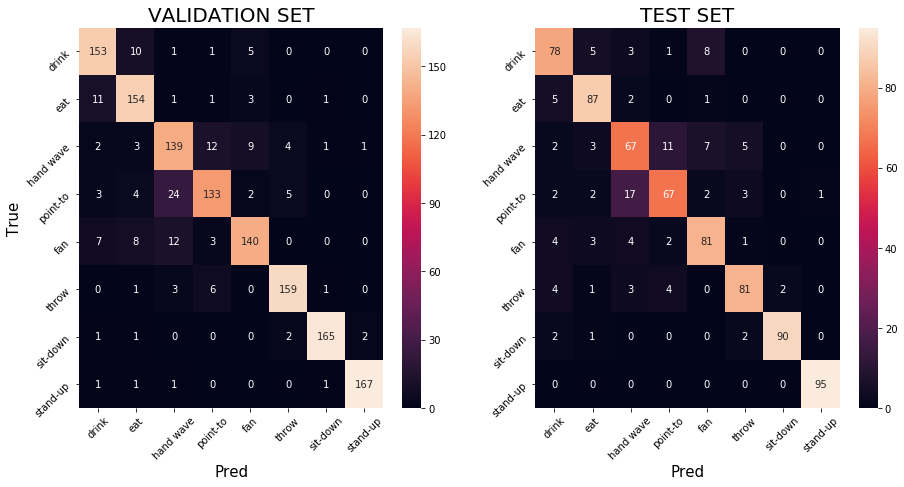

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Val acc: 0.27912087912087913
Test acc: 0.27140974967061926


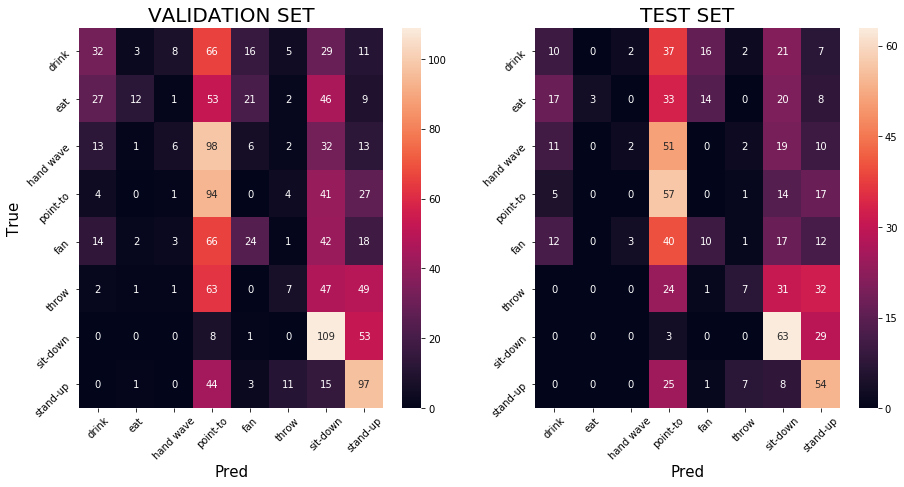

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame


KeyboardInterrupt: 

In [15]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        ## reshaping ###
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 17 * 2) 
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 17 * 2) 
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 17 * 2)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
        results.append((val_acc,test_acc,saved_model))

In [14]:
results

[(0.8864468864468864,
  0.8511198945981555,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfVideo.h5'>),
 (0.27912087912087913,
  0.27140974967061926,
  <DirEntry 'PoseNet-101-relativeToVideoCenter.h5'>),
 (0.8827838827838828,
  0.8313570487483531,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame.h5'>),
 (0.2293040293040293,
  0.21080368906455862,
  <DirEntry 'PoseNet-101-relativeToFrameCenter.h5'>),
 (0.1326007326007326,
  0.13175230566534915,
  <DirEntry 'PoseNet-101-relativeToVideoCenter-norm.h5'>),
 (0.18315018315018314,
  0.18972332015810275,
  <DirEntry 'PoseNet-101-relativeToFrameCenter-norm.h5'>),
 (0.8842490842490842,
  0.8642951251646904,
  <DirEntry 'PoseNet-101-relativeToUpperMiddleBottomCentersOfFrame-norm.h5'>),
 (0.28644688644688643,
  0.29907773386034253,
  <DirEntry 'PoseNet-101-relativeToNextFrame.h5'>),
 (0.21465201465201464, 0.2134387351778656, <DirEntry 'PoseNet-101-norm.h5'>),
 (0.136996336996337,
  0.13175230566534915,
  <DirEntry '

Val acc: 0.8864468864468864
Test acc: 0.8511198945981555


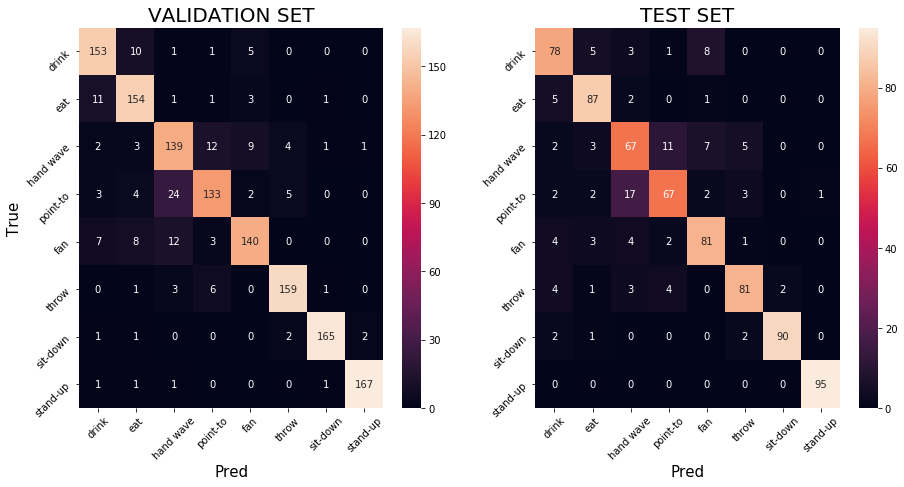

In [34]:
label_order = [1, 2, 31, 38, 49, 7, 8, 9]
model = loadedModel
y_val_pred = [label_order[i] for i in model.predict_classes(X_val)]
y_val_true = [label_order[np.argmax(i)] for i in y_val]
y_test_pred = [label_order[i] for i in model.predict_classes(X_test)]
y_test_true = [label_order[np.argmax(i)] for i in y_test]
val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
print("Val acc:",val_acc)
print("Test acc:",test_acc)
conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred, labels=label_order)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred, labels=label_order)
plotConfusionMatrixes(conf_mat_val,conf_mat_test)

In [21]:
y_val_pred

[31,
 2,
 1,
 1,
 2,
 49,
 1,
 7,
 9,
 7,
 1,
 38,
 2,
 8,
 7,
 8,
 1,
 9,
 8,
 2,
 38,
 2,
 38,
 2,
 1,
 1,
 31,
 38,
 31,
 2,
 49,
 31,
 7,
 1,
 31,
 49,
 31,
 31,
 9,
 8,
 49,
 31,
 7,
 2,
 49,
 49,
 38,
 38,
 49,
 9,
 31,
 49,
 2,
 31,
 38,
 7,
 49,
 31,
 1,
 49,
 1,
 38,
 8,
 7,
 31,
 49,
 9,
 9,
 8,
 8,
 7,
 8,
 2,
 7,
 49,
 7,
 2,
 8,
 7,
 7,
 1,
 7,
 31,
 8,
 2,
 7,
 2,
 31,
 31,
 8,
 38,
 9,
 38,
 2,
 9,
 31,
 7,
 8,
 38,
 2,
 31,
 8,
 7,
 49,
 31,
 8,
 49,
 8,
 1,
 38,
 9,
 8,
 2,
 49,
 8,
 38,
 9,
 2,
 49,
 31,
 38,
 38,
 1,
 7,
 31,
 7,
 49,
 49,
 9,
 49,
 8,
 1,
 49,
 9,
 31,
 1,
 1,
 1,
 8,
 7,
 8,
 49,
 9,
 1,
 7,
 8,
 31,
 2,
 38,
 2,
 31,
 8,
 8,
 7,
 2,
 7,
 38,
 49,
 31,
 8,
 49,
 8,
 49,
 49,
 38,
 7,
 9,
 9,
 38,
 7,
 2,
 8,
 2,
 9,
 38,
 8,
 8,
 8,
 7,
 49,
 9,
 8,
 2,
 8,
 31,
 8,
 9,
 38,
 8,
 38,
 31,
 49,
 9,
 8,
 9,
 31,
 49,
 2,
 31,
 1,
 9,
 38,
 8,
 1,
 8,
 8,
 7,
 49,
 1,
 9,
 1,
 38,
 8,
 1,
 8,
 9,
 2,
 49,
 2,
 8,
 1,
 2,
 7,
 1,
 2,
 38,
 49,
 2,
 31,

In [128]:
from os import scandir
from os.path import basename
from keras.models import load_model
savedModels = [f for f in scandir(SAVED_MODEL_FOLDER) if f.path[-3:] == ".h5"]
model_names = ["PoseNet-101","keypoint_rcnn_X_101_32x8d_FPN_3x"]
results = []
for model_to_analyse in model_names:
    datasetName = DATASET_FOLDER+model_to_analyse+"-SPLIT-dataset.pickle"
    with open(datasetName,'rb') as file_in:
        train_set, val_set, test_set = pickle.load(file_in)
    for saved_model in savedModels:
        modelName, preprocess_functions, normalise = fromFileNameToParameters(saved_model)
        if modelName != model_to_analyse:
            continue
        X_train, y_train, X_val, y_val, X_test, y_test = preprocessData(train_set, val_set, test_set, normalise, preprocess_functions)
        loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)
        print(basename(saved_model))
        val_acc, test_acc = getValTestAccuracy(loadedModel, X_val, y_val, X_test, y_test)
        print("Validation accuracy:",val_acc,"\nTest accuracy:",test_acc)
        results.append((basename(saved_model),val_acc, test_acc))
#         plotValTestResult(loadedModel, X_val, y_val, X_test, y_test)
print("DONE!")

classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each video
number of zeros train (after padding):		27738866 - 66.41%
number of zeros validation (after padding):	6942018 - 66.48%
number of zeros test (after padding):		3869268 - 66.64%
Dataset train shape:		 (5460, 225, 17, 2)
Dataset validation shape:	 (1365, 225, 17, 2)
Dataset test shape:		 (759, 225, 17, 2)
PoseNet-101-relativeToVideoCenter.h5
Validation accuracy: 0.8688644688644689 
Test accuracy: 0.8511198945981555
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
classes order: ['1' '2' '23' '31' '49' '7' '8' '9']
Adapting the data to the center of each video
Adapting the data to the center of each video
Adapting the data to the center of each vid

In [114]:
loadedModel = load_model(SAVED_MODEL_FOLDER+saved_model.name)

## continue training

In [13]:
# modelName = 'simple-model.h5'

In [14]:
# from keras.models import load_model
# model = load_model(modelName)

#Continue training
# model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)

# history = model.fit(X_train, y_train,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
# #                     validation_split=0.2
#                     validation_data=(X_val, y_val)
#                    )

Train on 5460 samples, validate on 1365 samples
Epoch 1/10
5460/5460 [==============================] - 35s 6ms/step - loss: 1.2101 - accuracy: 0.4623 - val_loss: 1.2212 - val_accuracy: 0.4718
Epoch 2/10
 368/5460 [=>............................] - ETA: 29s - loss: 1.1121 - accuracy: 0.4810

KeyboardInterrupt: 

# Display classification

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

label_order = [1, 2, 31, 38, 49, 7, 8, 9]
y_pred = loadedModel.predict_classes(X_val)
# label_order = ["1", "2", "31", "38", "49", "7", "8", "9"]
y_pred_labels = [label_order[i] for i in y_pred]
y_val_labels = [label_order[np.argmax(i)] for i in y_val]

In [45]:
accuracy_score(y_pred=y_pred_labels,y_true=y_val_labels)

0.8827838827838828

In [46]:
yTrue=y_pred_labels
yPred=y_test_labels
conf_mat = confusion_matrix(y_true=yTrue, y_pred=yPred, labels=label_order)
conf_mat

array([[133,  16,   4,   4,   8,   0,   0,   0],
       [ 10, 110,   4,   1,  12,   2,   0,   0],
       [  3,   5, 130,   8,   3,   4,   0,   0],
       [  6,   1,   2, 108,   6,   1,   1,   0],
       [  3,   4,   2,   1, 113,   1,   0,   0],
       [  0,   0,   3,   2,   0, 119,   0,   1],
       [  0,   0,   1,   0,   1,   2, 130,   0],
       [  0,   0,   1,   0,   0,   1,   4, 121]])

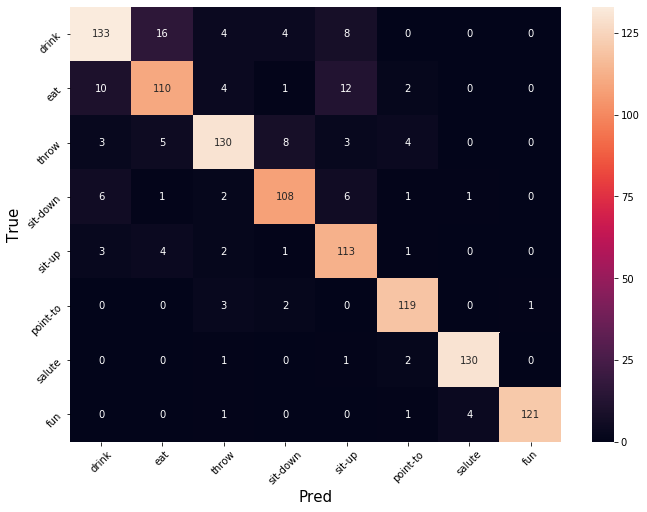

In [41]:
import seaborn as sn
plt.figure(figsize = (11,8))
ax = plt.axes()
labelString = ["drink", "eat", "throw", "sit-down", "sit-up", "point-to", "salute", "fun"]
ax = sn.heatmap(conf_mat, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# plt.title('', fontsize = 20) # title with fontsize 20
plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15

plt.show()

# ACTION_LABEL_SET = 
# A001  - A002 - A007 - A008     - A009   - A031               - A038   -  A049
# drink - eat - throw - sit down - sit up - point to something - salute - make a fun 


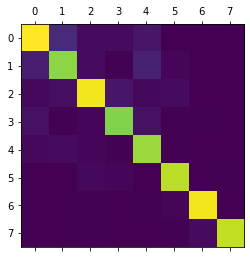

In [42]:
plt.matshow(conf_mat)